<a href="https://colab.research.google.com/github/susanta-pal/Deep-Learning/blob/main/FineTuningAndTrainingFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary libraries

In [ ]:
import torch
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import CIFAR100
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
# !pip install torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# Setup the Data Class (CIFAR100)
Always create classes for major modules. This will make your project modular, allowing you to switch different, in this case, datasets and test your model.
Out of all the advantages of this coding habit, one advantage of creating multiple objecs of the data class is that it allows you to perform ensemble learning.

In [ ]:
class DataModule():
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        # We define some augmentations that we would like to apply during training
        self.train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224, 4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # During validation we need to only normalize and resize
        self.val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    # This function sets up our datasets
    # which includes downloading and applying the augmentations
    def prepare_data(self):
        self.train_set = CIFAR100(root='./data', train=True, download=True, transform=self.train_transform)
        self.val_set = CIFAR100(root='./data', train=False, download=True, transform=self.val_transform)

    # This functions sets up the data loaders
    def setup(self):
        self.train_data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.val_data_loader = torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

    # This is simply a getter function for the training data loader
    def train_dataloader(self, prune=True):
        return self.train_data_loader

    # This is simply a getter function for the validation data loader
    def val_dataloader(self):
        return self.val_data_loader

# Setup the Model Class
Here we will define the model, its forward pass and its behaviour during each training/validation iteration

In [ ]:
class DLModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True, num_unfreeze_layers=0):
        super().__init__()
        # If you want to use the imagenet pretrained weights
        if pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
            # We freeze the entire model
            self.backbone.requires_grad_(False)
            # If you want to unfreeze some of the layers, then
            if num_unfreeze_layers > 0:
                # First find number of layers
                num_layers = 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        num_layers+=1
                # Following which unfreeze the last set of layers
                start_unfreezing_counter, counter = num_layers - num_unfreeze_layers, 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                    if counter >= start_unfreezing_counter:
                        module.requires_grad_(True)
        # Otherwise just initialize the network from scratch
        else:
            self.backbone = resnet18(weights=None)
            self.backbone.requires_grad_(True)
        # The resnet model comes with a 1000 neuron final layer for the imagenet dataset
        self.backbone.fc = torch.nn.Sequential(
            torch.nn.Linear(512, num_classes)
        )
        self.backbone.fc.requires_grad_(True)
        # for name, module in self.named_modules():
        #     print(name, all(param.requires_grad for param in module.parameters()))
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # Define the metrics
        self.train_acc1, self.val_acc1 = Accuracy(task="multiclass", num_classes=num_classes), Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc5, self.val_acc5 = Accuracy(task="multiclass", num_classes=num_classes, top_k=5), Accuracy(task="multiclass", num_classes=num_classes, top_k=5)

    # This function sets up the optimizer and scheduler that we will use
    def configure_optimizers(self, lr, momentum, max_epochs):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs)

    # This defines the behaviour of our model during the forward pass
    # Based on the defined behaviour, PyTorch sets up the backward pass
    def forward(self, x):
        out = self.backbone(x)
        return out

    # This function describes model behaviour per iteration during training
    def training_step(self, x, y):
        self.optimizer.zero_grad()
        preds = self.forward(x)
        self.train_acc1.update(preds, y)
        self.train_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    # Once the epoch is complete, we can call this function for inspecting the model's performance
    def on_training_epoch_end(self, loss, epoch):
        acc1, acc5 = self.train_acc1.compute().item(), self.train_acc5.compute().item()
        print(f"Epoch No: {epoch+1}\nTraining Loss: {loss}\n Training Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function describes model behaviour per iteration during validation
    def validation_step(self, x, y):
        preds = self.forward(x)
        self.val_acc1.update(preds, y)
        self.val_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        return loss.item()

    # Once the validation iterations are complete, we can call this function for inspecting the model's performance
    def on_validation_epoch_end(self, loss, epoch):
        acc1, acc5 = self.val_acc1.compute().item(), self.val_acc5.compute().item()
        print(f"Validation Loss: {loss}\nValidation Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function resets the metrics so that new results can be calculated for the next epoch
    def reset_metrics(self):
        self.train_acc1.reset(), self.train_acc5.reset()
        self.val_acc1.reset(), self.val_acc5.reset()

# Putting it all together
We first define some static and global variables

In [ ]:
# First define some static variables
num_classes = 100
num_epochs = 10
batch_size = 128
# Fine-tuning and training from scratch require different sets of learning rates
lr_finetune, lr_scratch = 0.001, 0.1
momentum = 0.9
device = torch.device("cuda")


# Define the data
data_module = DataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

Files already downloaded and verified
Files already downloaded and verified


# Shallow Fine-tuning
We first take a look at shallow fine-tuning (training only the final layer and keeping the remaining model frozen)

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
shallow_finetuning_val_acc = list()
# This variable will be used to save the per-epoch training loss
shallow_finetuning_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr_finetune, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    shallow_finetuning_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    shallow_finetuning_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Epoch No: 1
Training Loss: 4.143537996979931
 Training Accuracy: 0.12963999807834625 (Top-1)	  0.32269999384880066 (Top-5)


100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Validation Loss: 3.556681482097771
Validation Accuracy: 0.27619999647140503 (Top-1)	  0.5841000080108643 (Top-5)


100%|██████████| 391/391 [02:03<00:00,  3.16it/s]


Epoch No: 2
Training Loss: 3.2694397240953372
 Training Accuracy: 0.3371799886226654 (Top-1)	  0.6553599834442139 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


Validation Loss: 2.883368935766099
Validation Accuracy: 0.4115999937057495 (Top-1)	  0.73580002784729 (Top-5)


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch No: 3
Training Loss: 2.772677345349051
 Training Accuracy: 0.4224199950695038 (Top-1)	  0.740119993686676 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Validation Loss: 2.5103561697126944
Validation Accuracy: 0.46219998598098755 (Top-1)	  0.7674999833106995 (Top-5)


100%|██████████| 391/391 [02:08<00:00,  3.05it/s]


Epoch No: 4
Training Loss: 2.4779353952773695
 Training Accuracy: 0.4623199999332428 (Top-1)	  0.7717400193214417 (Top-5)


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Validation Loss: 2.2751428779167466
Validation Accuracy: 0.4927000105381012 (Top-1)	  0.7882000207901001 (Top-5)


100%|██████████| 391/391 [02:10<00:00,  3.00it/s]


Epoch No: 5
Training Loss: 2.298780562627651
 Training Accuracy: 0.48166000843048096 (Top-1)	  0.7879999876022339 (Top-5)


100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


Validation Loss: 2.123576642591742
Validation Accuracy: 0.5070000290870667 (Top-1)	  0.8011999726295471 (Top-5)


100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch No: 6
Training Loss: 2.161767344035761
 Training Accuracy: 0.4978199899196625 (Top-1)	  0.8001999855041504 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


Validation Loss: 2.0110215024103093
Validation Accuracy: 0.5268999934196472 (Top-1)	  0.8130999803543091 (Top-5)


100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch No: 7
Training Loss: 2.0669423036868007
 Training Accuracy: 0.50764000415802 (Top-1)	  0.8067399859428406 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Validation Loss: 1.9438050049769728
Validation Accuracy: 0.5266000032424927 (Top-1)	  0.8159999847412109 (Top-5)


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Epoch No: 8
Training Loss: 1.9894669598630628
 Training Accuracy: 0.51774001121521 (Top-1)	  0.8126199841499329 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Validation Loss: 1.8833020653905748
Validation Accuracy: 0.5351999998092651 (Top-1)	  0.8216999769210815 (Top-5)


100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch No: 9
Training Loss: 1.9370593628310182
 Training Accuracy: 0.5234599709510803 (Top-1)	  0.8183199763298035 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Validation Loss: 1.8374161705186096
Validation Accuracy: 0.5378000140190125 (Top-1)	  0.8248999714851379 (Top-5)


100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


Epoch No: 10
Training Loss: 1.8869951847569106
 Training Accuracy: 0.5290600061416626 (Top-1)	  0.8228800296783447 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

Validation Loss: 1.7904960716827005
Validation Accuracy: 0.5465999841690063 (Top-1)	  0.8305000066757202 (Top-5)


# Deep Fine-tuning
We now take a look at deep fine-tuning (training some the final layers while keeping the remaining layers frozen)

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
deep_finetuning_val_acc = list()
# This variable will be used to save the per-epoch training loss
deep_finetuning_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=31).to(device)
model.configure_optimizers(lr=lr_finetune, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    deep_finetuning_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    deep_finetuning_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 391/391 [03:00<00:00,  2.17it/s]


Epoch No: 1
Training Loss: 3.360540188791807
 Training Accuracy: 0.27649998664855957 (Top-1)	  0.5421199798583984 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


Validation Loss: 2.1749073055726065
Validation Accuracy: 0.49300000071525574 (Top-1)	  0.8090999722480774 (Top-5)


100%|██████████| 391/391 [02:35<00:00,  2.51it/s]


Epoch No: 2
Training Loss: 1.815080723189332
 Training Accuracy: 0.5642399787902832 (Top-1)	  0.8628600239753723 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.49it/s]


Validation Loss: 1.4513924921615213
Validation Accuracy: 0.6290000081062317 (Top-1)	  0.897599995136261 (Top-5)


100%|██████████| 391/391 [02:57<00:00,  2.21it/s]


Epoch No: 3
Training Loss: 1.3366360300032378
 Training Accuracy: 0.657260000705719 (Top-1)	  0.9146999716758728 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Validation Loss: 1.1674378106865702
Validation Accuracy: 0.6820999979972839 (Top-1)	  0.9300000071525574 (Top-5)


100%|██████████| 391/391 [02:47<00:00,  2.33it/s]


Epoch No: 4
Training Loss: 1.1134793711135456
 Training Accuracy: 0.7025799751281738 (Top-1)	  0.936020016670227 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


Validation Loss: 1.0297166810760014
Validation Accuracy: 0.7095999717712402 (Top-1)	  0.9417999982833862 (Top-5)


100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch No: 5
Training Loss: 0.9675247932943847
 Training Accuracy: 0.7340400218963623 (Top-1)	  0.9498800039291382 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


Validation Loss: 0.9348241286941722
Validation Accuracy: 0.7304999828338623 (Top-1)	  0.95169997215271 (Top-5)


100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch No: 6
Training Loss: 0.8703568498496814
 Training Accuracy: 0.7584400177001953 (Top-1)	  0.9576399922370911 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


Validation Loss: 0.8793888786171056
Validation Accuracy: 0.745199978351593 (Top-1)	  0.9538999795913696 (Top-5)


100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch No: 7
Training Loss: 0.7940242700564587
 Training Accuracy: 0.7751399874687195 (Top-1)	  0.9646999835968018 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


Validation Loss: 0.8331393825856945
Validation Accuracy: 0.7555999755859375 (Top-1)	  0.9587000012397766 (Top-5)


100%|██████████| 391/391 [02:29<00:00,  2.61it/s]


Epoch No: 8
Training Loss: 0.7288752303403967
 Training Accuracy: 0.7936400175094604 (Top-1)	  0.9687399864196777 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


Validation Loss: 0.8006902291804929
Validation Accuracy: 0.7656999826431274 (Top-1)	  0.9581999778747559 (Top-5)


100%|██████████| 391/391 [02:31<00:00,  2.59it/s]


Epoch No: 9
Training Loss: 0.676946060355667
 Training Accuracy: 0.8054599761962891 (Top-1)	  0.9723399877548218 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


Validation Loss: 0.7742359340190887
Validation Accuracy: 0.7716000080108643 (Top-1)	  0.9609000086784363 (Top-5)


100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Epoch No: 10
Training Loss: 0.6285421682135833
 Training Accuracy: 0.8198599815368652 (Top-1)	  0.9764000177383423 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.41it/s]

Validation Loss: 0.7532979461211192
Validation Accuracy: 0.7777000069618225 (Top-1)	  0.9632999897003174 (Top-5)


# Training from Scratch
Finally, we train the ResNet18 model from scratch on the CIFAR100 dataset

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
scratch_val_acc = list()
# This variable will be used to save the per-epoch training loss
scratch_train_loss = list()


# Define the model
model = DLModel(num_classes=num_classes, pretrained=False, num_unfreeze_layers=0).to(device)
model.configure_optimizers(lr=lr_scratch, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    scratch_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    scratch_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 391/391 [03:15<00:00,  2.00it/s]


Epoch No: 1
Training Loss: 3.9362897683897287
 Training Accuracy: 0.09390000253915787 (Top-1)	  0.2949399948120117 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Validation Loss: 3.5744882837126526
Validation Accuracy: 0.14990000426769257 (Top-1)	  0.39809998869895935 (Top-5)


100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


Epoch No: 2
Training Loss: 3.3242647403951193
 Training Accuracy: 0.19247999787330627 (Top-1)	  0.4685800075531006 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.14it/s]


Validation Loss: 3.18125677712356
Validation Accuracy: 0.21690000593662262 (Top-1)	  0.5223000049591064 (Top-5)


100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


Epoch No: 3
Training Loss: 2.7773542184658977
 Training Accuracy: 0.2921200096607208 (Top-1)	  0.6059799790382385 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Validation Loss: 2.6387353878986985
Validation Accuracy: 0.31869998574256897 (Top-1)	  0.6424999833106995 (Top-5)


100%|██████████| 391/391 [03:18<00:00,  1.97it/s]


Epoch No: 4
Training Loss: 2.2871535467674664
 Training Accuracy: 0.39160001277923584 (Top-1)	  0.7196800112724304 (Top-5)


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


Validation Loss: 2.179469469227368
Validation Accuracy: 0.41760000586509705 (Top-1)	  0.7407000064849854 (Top-5)


100%|██████████| 391/391 [03:26<00:00,  1.89it/s]


Epoch No: 5
Training Loss: 1.9357049663353454
 Training Accuracy: 0.4713999927043915 (Top-1)	  0.7889599800109863 (Top-5)


100%|██████████| 79/79 [01:04<00:00,  1.22it/s]


Validation Loss: 2.0301800257042992
Validation Accuracy: 0.4632999897003174 (Top-1)	  0.7717999815940857 (Top-5)


100%|██████████| 391/391 [12:52<00:00,  1.98s/it]


Epoch No: 6
Training Loss: 1.6803211263378564
 Training Accuracy: 0.5302000045776367 (Top-1)	  0.8345800042152405 (Top-5)


100%|██████████| 79/79 [00:50<00:00,  1.56it/s]


Validation Loss: 1.8959374065640606
Validation Accuracy: 0.4902999997138977 (Top-1)	  0.7936999797821045 (Top-5)


100%|██████████| 391/391 [12:21<00:00,  1.90s/it]


Epoch No: 7
Training Loss: 1.4956904857055
 Training Accuracy: 0.5760999917984009 (Top-1)	  0.8659399747848511 (Top-5)


100%|██████████| 79/79 [01:01<00:00,  1.29it/s]


Validation Loss: 1.7226414273056803
Validation Accuracy: 0.5333999991416931 (Top-1)	  0.8220999836921692 (Top-5)


100%|██████████| 391/391 [12:28<00:00,  1.91s/it]


Epoch No: 8
Training Loss: 1.3323778226552412
 Training Accuracy: 0.6187400221824646 (Top-1)	  0.887499988079071 (Top-5)


100%|██████████| 79/79 [00:57<00:00,  1.38it/s]


Validation Loss: 1.6979890005497993
Validation Accuracy: 0.5349000096321106 (Top-1)	  0.83160001039505 (Top-5)


100%|██████████| 391/391 [07:54<00:00,  1.21s/it]


Epoch No: 9
Training Loss: 1.1968853825803303
 Training Accuracy: 0.653439998626709 (Top-1)	  0.9073799848556519 (Top-5)


100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


Validation Loss: 1.4876124707958367
Validation Accuracy: 0.5819000005722046 (Top-1)	  0.8583999872207642 (Top-5)


100%|██████████| 391/391 [03:37<00:00,  1.80it/s]


Epoch No: 10
Training Loss: 1.0893634515040367
 Training Accuracy: 0.6795600056648254 (Top-1)	  0.921459972858429 (Top-5)


100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Validation Loss: 1.4282779965219619
Validation Accuracy: 0.6054999828338623 (Top-1)	  0.8669000267982483 (Top-5)


# Comparisons
Now that we have evaluated the models under three different forms of training, let us compare them

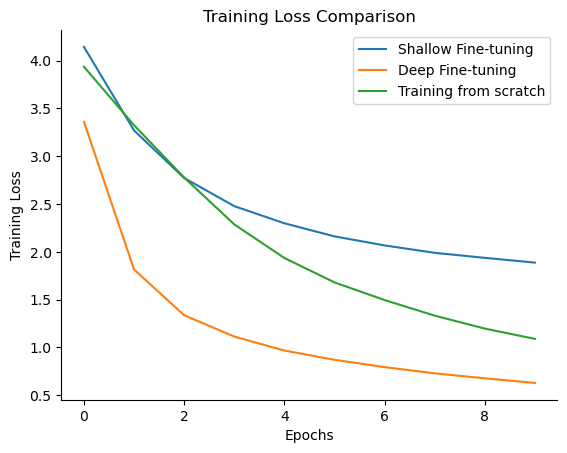

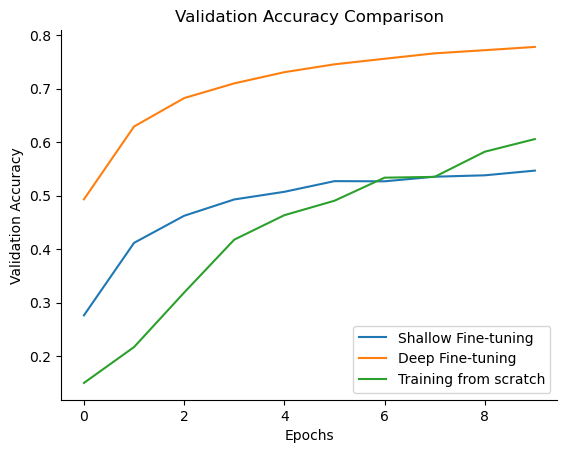

In [ ]:
# Comparing the Training loss per epoch
sns.lineplot(x=np.arange(len(shallow_finetuning_train_loss)), y=shallow_finetuning_train_loss, label="Shallow Fine-tuning")
sns.lineplot(x=np.arange(len(deep_finetuning_train_loss)), y=deep_finetuning_train_loss, label="Deep Fine-tuning")
sns.lineplot(x=np.arange(len(scratch_train_loss)), y=scratch_train_loss, label="Training from scratch")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
sns.despine()
plt.title("Training Loss Comparison")
plt.show()
plt.close()

# Comparing the validation Accuracies per epoch
sns.lineplot(x=np.arange(len(shallow_finetuning_val_acc)), y=shallow_finetuning_val_acc, label="Shallow Fine-tuning")
sns.lineplot(x=np.arange(len(deep_finetuning_val_acc)), y=deep_finetuning_val_acc, label="Deep Fine-tuning")
sns.lineplot(x=np.arange(len(scratch_val_acc)), y=scratch_val_acc, label="Training from scratch")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.title("Validation Accuracy Comparison")
plt.show()